In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from math import *

import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.nn import Parameter
import torch.optim
from torch.autograd import Variable

import IPython.display as display
import time

import copy

import numexpr
import tqdm

import signal

def tovar(x):
    return torch.FloatTensor(x).cuda()

def toivar(x):
    return torch.LongTensor(x).cuda()

In [138]:
symbols = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '.']
sdict = { '0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5':5, '6':6, '7':7, '8':8, '9':9, '.':10 }

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.l1 = nn.LSTM(11, 32, bidirectional=True, batch_first=True)
        self.l2 = nn.LSTM(64, 32, bidirectional=True, batch_first=True)
        self.l3 = nn.LSTM(64, 32, bidirectional=True, batch_first=True)
        self.l4 = nn.Conv1d(64, 11, 1)
        
        self.optim = torch.optim.Adam(self.parameters(), lr=1e-2)
        
    def forward(self, x):
        # x is batch x features x len
        z = x.transpose(1,2).contiguous()
        
        z, _ = self.l1(z)
        z, _ = self.l2(z)
        z, _ = self.l3(z)
        z = z.transpose(1,2).contiguous() # batch x features x len
        
        z = F.log_softmax(self.l4(z),dim=1)
        
        return z

In [139]:
def getData(N, LEN=16, scale=100):
    x0 = scale*np.abs(np.random.randn(N)).astype(np.float64)
    y0 = np.sqrt(x0)
    
    xs = []
    ys = []
    
    for i in range(N):
        oh = np.zeros((11,LEN))
        xstr = '%.16f' % x0[i]
        if len(xstr)>LEN:
            xstr = xstr[:LEN]
            
        ofs = LEN-len(xstr)
        for j in range(ofs):
            oh[0,j] = 1
        
        for j in range(len(xstr)):
            oh[sdict[xstr[j]], j+ofs] = 1
        
        xs.append(oh)
        
        oh = np.zeros((11,LEN))
        xstr = '%.16f' % y0[i]
        if len(xstr)>LEN:
            xstr = xstr[:LEN]
        
        ofs = LEN-len(xstr)
        for j in range(ofs):
            oh[0,j] = 1
        
        for j in range(len(xstr)):
            oh[sdict[xstr[j]], j+ofs] = 1
        
        ys.append(oh)
    
    return np.array(xs), np.array(ys)

In [111]:
xdata, ydata = getData(100000, scale=10000)

In [112]:
def onehotToString(x):
    num = ""
    
    for i in range(x.shape[0]):
        j = np.argmax(x[:,i])
        num += symbols[j]
    return num

In [140]:
net = Net().cuda()

BS = 500
ts_err = []

In [ ]:
for epoch in range(150):
    if epoch==50:
        for p in net.optim.param_groups:
            p['lr'] = 1e-3
            
    if epoch==100:
        for p in net.optim.param_groups:
            p['lr'] = 1e-4
            
    for i in range(90000//BS):
        net.zero_grad()
        y = tovar(ydata[i*BS:i*BS+BS])
        p = net.forward(tovar(xdata[i*BS:i*BS+BS]))
        
        loss = -torch.mean(torch.sum(p*y, 1))
        loss.backward()
        torch.nn.utils.clip_grad_norm(net.parameters(),0.1)
        
        net.optim.step()
    
    err = []
    for i in range(90000//BS, 100000//BS):
        y = tovar(ydata[i*BS:i*BS+BS])
        p = net.forward(tovar(xdata[i*BS:i*BS+BS]))
        
        loss = -torch.mean(torch.sum(p*y, 1))
        err.append(loss.cpu().detach().item())
    
    ts_err.append(np.mean(err))
    
    plt.clf()
    plt.plot(ts_err)
    
    display.clear_output(wait=True)
    display.display(plt.gcf())
    time.sleep(0.01)

In [ ]:
torch.save(net.state_dict(), open("base_lstm_model.pth","wb"))

In [154]:
xdata2, ydata2 = getData(10000, scale=10000)

net = Net().cuda()
net.load_state_dict(torch.load("base_lstm_model.pth"))

truevals = []
predvals = []

losses = []

for i in range(10000//BS):
    y = tovar(ydata2[i*BS:i*BS+BS])
    p = net.forward(tovar(xdata2[i*BS:i*BS+BS]))
    loss = -torch.sum(p*y, 1).detach()
    losses.append(loss)
    
    p = p.cpu().detach().numpy()
    y = y.cpu().detach().numpy()
    
    for idx in range(BS):
        truevals.append(float(onehotToString(y[idx])))
        pstr = onehotToString(p[idx])
        try:
            predvals.append(float(pstr))
        except:
            predvals.append(0)

base_perf = torch.mean(torch.cat(losses,0),0).cpu().detach().numpy()
truevals = np.array(truevals)
predvals = np.array(predvals)

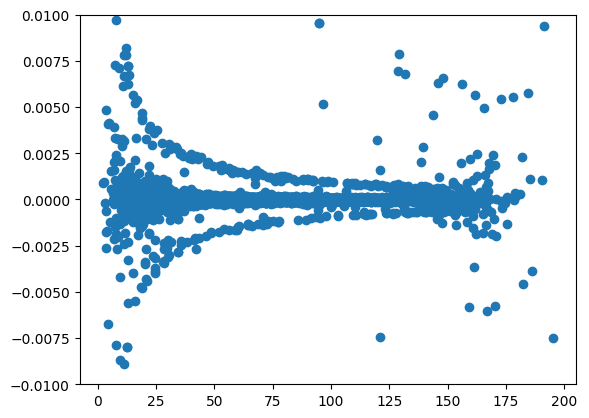

In [155]:
plt.scatter(truevals, (truevals-predvals)/truevals)
plt.ylim(-0.01,0.01)
plt.show()

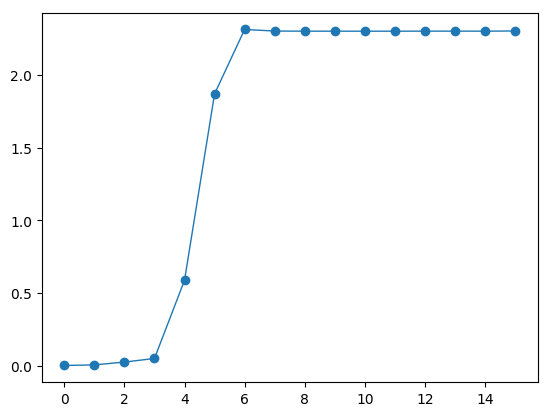

In [156]:
plt.plot(base_perf,'o-')
plt.show()

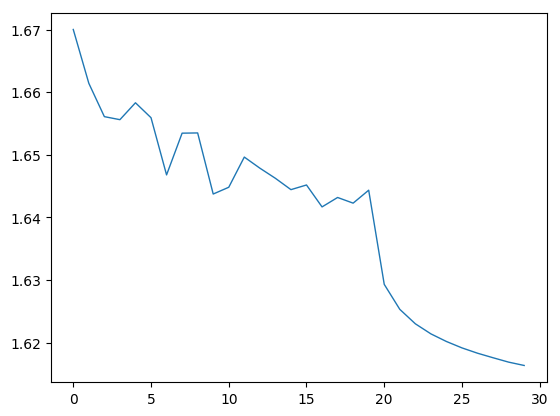

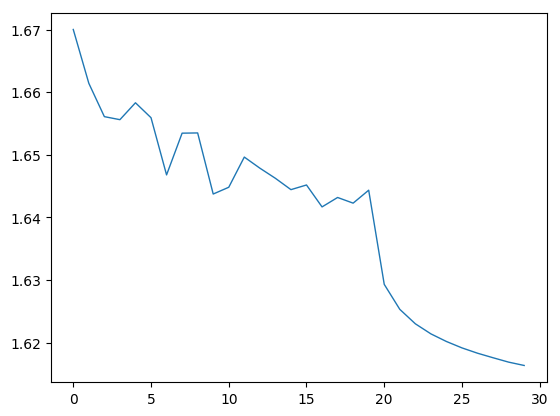

In [159]:
mod_perfs = []

for n1 in range(16):
    net = Net().cuda()
    net.load_state_dict(torch.load("base_lstm_model.pth"))
    
    for p in net.optim.param_groups:
        p['lr'] = 1e-2
        
    ts_err = []
    for epoch in range(30):
        if epoch == 20:
            for p in net.optim.param_groups:
                p['lr'] = 1e-4
            
        for i in range(90000//BS):
            net.zero_grad()
            y = tovar(ydata[i*BS:i*BS+BS])
            x = tovar(xdata[i*BS:i*BS+BS])
            x[:,:,n1] = 0
            
            p = net.forward(x)

            loss = -torch.mean(torch.sum(p*y, 1))
            loss.backward()
            torch.nn.utils.clip_grad_norm(net.parameters(),0.1)

            net.optim.step()

        err = []
        for i in range(90000//BS, 100000//BS):
            y = tovar(ydata[i*BS:i*BS+BS])
            x = tovar(xdata[i*BS:i*BS+BS])
            x[:,:,n1] = 0
            p = net.forward(x)

            loss = -torch.mean(torch.sum(p*y, 1))
            err.append(loss.cpu().detach().item())

        ts_err.append(np.mean(err))

        plt.clf()
        plt.plot(ts_err)

        display.clear_output(wait=True)
        display.display(plt.gcf())
        time.sleep(0.01)
        
    losses = []

    for i in range(10000//BS):
        y = tovar(ydata2[i*BS:i*BS+BS])
        x = tovar(xdata2[i*BS:i*BS+BS])
        x[:,:,n1] = 0
        p = net.forward(x)
        loss = -torch.sum(p*y, 1).detach()
        losses.append(loss)

    perf = torch.mean(torch.cat(losses,0),0).cpu().detach().numpy()
    mod_perfs.append(perf)

In [160]:
mod_perfs = np.array(mod_perfs)

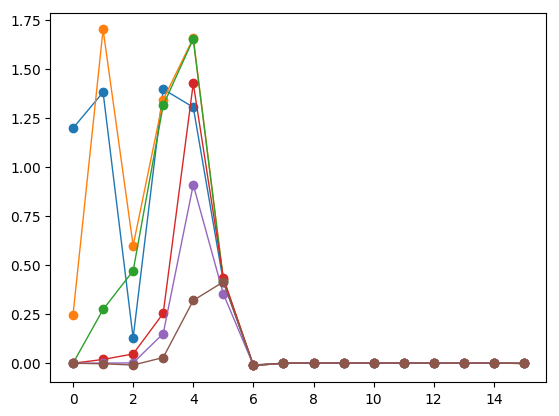

In [181]:
plt.plot(mod_perfs[0]-base_perf, 'o-')
plt.plot(mod_perfs[1]-base_perf, 'o-')
plt.plot(mod_perfs[2]-base_perf, 'o-')
plt.plot(mod_perfs[3]-base_perf, 'o-')
plt.plot(mod_perfs[4]-base_perf, 'o-')
plt.plot(mod_perfs[5]-base_perf, 'o-')
plt.show()

infoloss = mod_perfs-base_perf[np.newaxis,:]

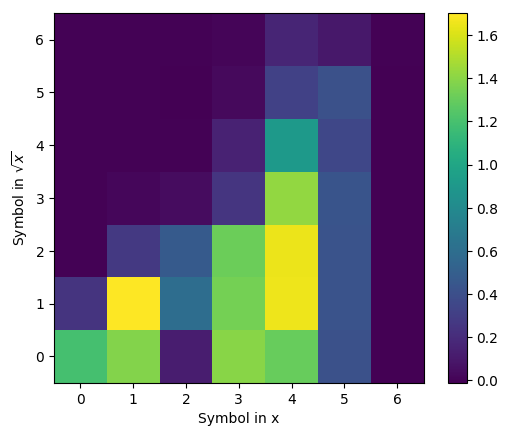

In [186]:
plt.imshow(infoloss)
plt.xlabel("Symbol in x")
plt.ylabel("Symbol in $\\sqrt{x}$")
plt.xlim(-0.5,6.5)
plt.ylim(-0.5,6.5)
plt.colorbar()
plt.show()

In [183]:
np.sum(infoloss,axis=1)

array([5.8124824 , 5.9651246 , 4.12185   , 2.1657476 , 1.3999588 ,
       0.73615324, 0.26631296, 0.25695118, 0.2751087 , 0.2646872 ,
       0.27360925, 0.26520067, 0.2731041 , 0.27184463, 0.26469973,
       0.26284766], dtype=float32)